<a href="https://colab.research.google.com/github/UdayShankar8/TSAI-S5/blob/master/EVA4S5F4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [72]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


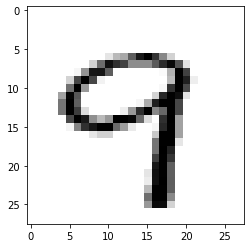

In [73]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

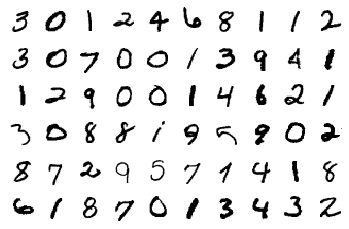

In [74]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 26 #Rf - 1

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 24 #Rf - 3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 22 #Rf - 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            
            nn.ReLU()
        ) # output_size = 11 #Rf - 6

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 9 #Rf - 10
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 7 #Rf - 14

        # TRANSITION BLOCK 2
        #self.pool2 = nn.MaxPool2d(2, 2) # output_size = 11
        #self.convblock7 = nn.Sequential(
            #nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            
            #nn.ReLU()
        #) # output_size = 3 #Rf - 15

        # OUTPUT BLOCK
        #self.convblock7 = nn.Sequential(
            #nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            #nn.ReLU()
        #) # output_size = 7 #Rf - 18
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1 #Rf - 23
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=2)
        )

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.pool2(x)
        #x = self.convblock7(x)
        x = self.gap(x) 
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [107]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
           Dropout-7           [-1, 10, 24, 24]               0
              ReLU-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 20, 22, 22]           1,800
      BatchNorm2d-10           [-1, 20, 22, 22]              40
          Dropout-11           [-1, 20, 22, 22]               0
             ReLU-12           [-1, 20, 22, 22]               0
        MaxPool2d-13           [-1, 20, 11, 11]               0
           Conv2d-14           [-1

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [109]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0



Loss=2.3572216033935547 Batch_id=0 Accuracy=7.81:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.3572216033935547 Batch_id=0 Accuracy=7.81:   0%|          | 1/469 [00:00<02:49,  2.75it/s]
Loss=2.317636013031006 Batch_id=1 Accuracy=8.20:   0%|          | 1/469 [00:00<02:49,  2.75it/s] 
Loss=2.2425484657287598 Batch_id=2 Accuracy=11.98:   0%|          | 1/469 [00:00<02:49,  2.75it/s]
Loss=2.278892755508423 Batch_id=3 Accuracy=12.89:   0%|          | 1/469 [00:00<02:49,  2.75it/s] 
Loss=2.278892755508423 Batch_id=3 Accuracy=12.89:   1%|          | 4/469 [00:00<02:02,  3.78it/s]
Loss=2.266810655593872 Batch_id=4 Accuracy=13.75:   1%|          | 4/469 [00:00<02:02,  3.78it/s]
Loss=2.2417287826538086 Batch_id=5 Accuracy=14.58:   1%|          | 4/469 [00:00<02:02,  3.78it/s]
Loss=2.2370047569274902 Batch_id=6 Accuracy=15.62:   1%|          | 4/469 [00:00<02:02,  3.78it/s]
Loss=2.152005434036255 Batch_id=7 Accuracy=17.29:   1%|          | 4/469 [00:00<02:02,  3.78it/s] 
Loss=2.152005434036255


Test set: Average loss: 0.0788, Accuracy: 9766/10000 (97.66%)

EPOCH: 1



Loss=0.08409492671489716 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.08409492671489716 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:28,  3.15it/s]
Loss=0.07299283146858215 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:28,  3.15it/s]
Loss=0.0651974231004715 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:28,  3.15it/s] 
Loss=0.09879110753536224 Batch_id=3 Accuracy=98.44:   0%|          | 1/469 [00:00<02:28,  3.15it/s]
Loss=0.09670285880565643 Batch_id=4 Accuracy=98.28:   0%|          | 1/469 [00:00<02:28,  3.15it/s]
Loss=0.09670285880565643 Batch_id=4 Accuracy=98.28:   1%|          | 5/469 [00:00<01:47,  4.31it/s]
Loss=0.06316100060939789 Batch_id=5 Accuracy=98.44:   1%|          | 5/469 [00:00<01:47,  4.31it/s]
Loss=0.049634162336587906 Batch_id=6 Accuracy=98.44:   1%|          | 5/469 [00:00<01:47,  4.31it/s]
Loss=0.05469764396548271 Batch_id=7 Accuracy=98.34:   1%|          | 5/469 [00:00<01:47,  4.31it/s] 
Loss=


Test set: Average loss: 0.0525, Accuracy: 9847/10000 (98.47%)

EPOCH: 2



Loss=0.049050427973270416 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.049050427973270416 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:35,  3.01it/s]
Loss=0.07510625571012497 Batch_id=1 Accuracy=97.66:   0%|          | 1/469 [00:00<02:35,  3.01it/s] 
Loss=0.0379142165184021 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<02:35,  3.01it/s] 
Loss=0.10133316367864609 Batch_id=3 Accuracy=97.85:   0%|          | 1/469 [00:00<02:35,  3.01it/s]
Loss=0.06522820144891739 Batch_id=4 Accuracy=97.81:   0%|          | 1/469 [00:00<02:35,  3.01it/s]
Loss=0.06522820144891739 Batch_id=4 Accuracy=97.81:   1%|          | 5/469 [00:00<01:52,  4.13it/s]
Loss=0.0490795336663723 Batch_id=5 Accuracy=98.05:   1%|          | 5/469 [00:00<01:52,  4.13it/s] 
Loss=0.05586056783795357 Batch_id=6 Accuracy=97.99:   1%|          | 5/469 [00:00<01:52,  4.13it/s]
Loss=0.07932187616825104 Batch_id=7 Accuracy=97.95:   1%|          | 5/469 [00:00<01:52,  4.13it/s]
Loss


Test set: Average loss: 0.0444, Accuracy: 9869/10000 (98.69%)

EPOCH: 3



Loss=0.0952175036072731 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.0952175036072731 Batch_id=0 Accuracy=96.88:   0%|          | 1/469 [00:00<02:38,  2.95it/s]
Loss=0.060853924602270126 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<02:38,  2.95it/s]
Loss=0.10294301807880402 Batch_id=2 Accuracy=97.14:   0%|          | 1/469 [00:00<02:38,  2.95it/s] 
Loss=0.11433069407939911 Batch_id=3 Accuracy=96.88:   0%|          | 1/469 [00:00<02:38,  2.95it/s]
Loss=0.04570506513118744 Batch_id=4 Accuracy=97.19:   0%|          | 1/469 [00:00<02:38,  2.95it/s]
Loss=0.04570506513118744 Batch_id=4 Accuracy=97.19:   1%|          | 5/469 [00:00<01:53,  4.09it/s]
Loss=0.07484303414821625 Batch_id=5 Accuracy=97.27:   1%|          | 5/469 [00:00<01:53,  4.09it/s]
Loss=0.019452162086963654 Batch_id=6 Accuracy=97.66:   1%|          | 5/469 [00:00<01:53,  4.09it/s]
Loss=0.033645905554294586 Batch_id=7 Accuracy=97.75:   1%|          | 5/469 [00:00<01:53,  4.09it/s]
Loss=


Test set: Average loss: 0.0443, Accuracy: 9866/10000 (98.66%)

EPOCH: 4



Loss=0.04015874117612839 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.04015874117612839 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:41,  2.90it/s]
Loss=0.04689202085137367 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:41,  2.90it/s]
Loss=0.011054106056690216 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:41,  2.90it/s]
Loss=0.051447656005620956 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<02:41,  2.90it/s]
Loss=0.051447656005620956 Batch_id=3 Accuracy=99.02:   1%|          | 4/469 [00:00<01:57,  3.97it/s]
Loss=0.05502542853355408 Batch_id=4 Accuracy=98.91:   1%|          | 4/469 [00:00<01:57,  3.97it/s] 
Loss=0.0670136883854866 Batch_id=5 Accuracy=98.70:   1%|          | 4/469 [00:00<01:57,  3.97it/s] 
Loss=0.036805808544158936 Batch_id=6 Accuracy=98.55:   1%|          | 4/469 [00:00<01:57,  3.97it/s]
Loss=0.06819532811641693 Batch_id=7 Accuracy=98.44:   1%|          | 4/469 [00:00<01:57,  3.97it/s] 
L


Test set: Average loss: 0.0378, Accuracy: 9887/10000 (98.87%)

EPOCH: 5



Loss=0.021262798458337784 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.021262798458337784 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:33,  3.06it/s]
Loss=0.0560460239648819 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:33,  3.06it/s]  
Loss=0.029152873903512955 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<02:33,  3.06it/s]
Loss=0.1366923451423645 Batch_id=3 Accuracy=97.46:   0%|          | 1/469 [00:00<02:33,  3.06it/s]  
Loss=0.04640818014740944 Batch_id=4 Accuracy=97.66:   0%|          | 1/469 [00:00<02:33,  3.06it/s]
Loss=0.04640818014740944 Batch_id=4 Accuracy=97.66:   1%|          | 5/469 [00:00<01:50,  4.21it/s]
Loss=0.017146259546279907 Batch_id=5 Accuracy=98.05:   1%|          | 5/469 [00:00<01:50,  4.21it/s]
Loss=0.06884734332561493 Batch_id=6 Accuracy=98.21:   1%|          | 5/469 [00:00<01:50,  4.21it/s] 
Loss=0.057199627161026 Batch_id=7 Accuracy=98.24:   1%|          | 5/469 [00:00<01:50,  4.21it/s]  



Test set: Average loss: 0.0330, Accuracy: 9904/10000 (99.04%)

EPOCH: 6



Loss=0.01972433552145958 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.01972433552145958 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:35,  3.02it/s]
Loss=0.008004482835531235 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:35,  3.02it/s]
Loss=0.03771248459815979 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:35,  3.02it/s] 
Loss=0.007364340126514435 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<02:35,  3.02it/s]
Loss=0.007364340126514435 Batch_id=3 Accuracy=99.41:   1%|          | 4/469 [00:00<01:53,  4.11it/s]
Loss=0.051156897097826004 Batch_id=4 Accuracy=99.06:   1%|          | 4/469 [00:00<01:53,  4.11it/s]
Loss=0.0043649822473526 Batch_id=5 Accuracy=99.22:   1%|          | 4/469 [00:00<01:53,  4.11it/s]  
Loss=0.027710363268852234 Batch_id=6 Accuracy=99.22:   1%|          | 4/469 [00:00<01:53,  4.11it/s]
Loss=0.04045441001653671 Batch_id=7 Accuracy=99.12:   1%|          | 4/469 [00:00<01:53,  4.11it/s] 


Test set: Average loss: 0.0312, Accuracy: 9897/10000 (98.97%)

EPOCH: 7



Loss=0.011561166495084763 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.011561166495084763 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:11,  3.57it/s]
Loss=0.011201299726963043 Batch_id=1 Accuracy=100.00:   0%|          | 1/469 [00:00<02:11,  3.57it/s]
Loss=0.01718323305249214 Batch_id=2 Accuracy=100.00:   0%|          | 1/469 [00:00<02:11,  3.57it/s] 
Loss=0.01718323305249214 Batch_id=2 Accuracy=100.00:   1%|          | 3/469 [00:00<01:39,  4.70it/s]
Loss=0.0587598979473114 Batch_id=3 Accuracy=99.41:   1%|          | 3/469 [00:00<01:39,  4.70it/s]  
Loss=0.08173463493585587 Batch_id=4 Accuracy=98.75:   1%|          | 3/469 [00:00<01:39,  4.70it/s]
Loss=0.052809979766607285 Batch_id=5 Accuracy=98.83:   1%|          | 3/469 [00:00<01:39,  4.70it/s]
Loss=0.008128516376018524 Batch_id=6 Accuracy=99.00:   1%|          | 3/469 [00:00<01:39,  4.70it/s]
Loss=0.026027686893939972 Batch_id=7 Accuracy=99.02:   1%|          | 3/469 [00:00<01:39,  4.70


Test set: Average loss: 0.0306, Accuracy: 9901/10000 (99.01%)

EPOCH: 8



Loss=0.011277217417955399 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.011277217417955399 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:35,  3.01it/s]
Loss=0.05319526791572571 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:35,  3.01it/s]  
Loss=0.04609141871333122 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:35,  3.01it/s]
Loss=0.027848146855831146 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<02:35,  3.01it/s]
Loss=0.027848146855831146 Batch_id=3 Accuracy=99.02:   1%|          | 4/469 [00:00<01:53,  4.10it/s]
Loss=0.038883719593286514 Batch_id=4 Accuracy=99.06:   1%|          | 4/469 [00:00<01:53,  4.10it/s]
Loss=0.03840290755033493 Batch_id=5 Accuracy=98.96:   1%|          | 4/469 [00:00<01:53,  4.10it/s] 
Loss=0.03295820206403732 Batch_id=6 Accuracy=99.00:   1%|          | 4/469 [00:00<01:53,  4.10it/s]
Loss=0.03661162406206131 Batch_id=7 Accuracy=98.93:   1%|          | 4/469 [00:00<01:53,  4.10it/


Test set: Average loss: 0.0344, Accuracy: 9889/10000 (98.89%)

EPOCH: 9



Loss=0.045153677463531494 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.045153677463531494 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:14,  3.47it/s]
Loss=0.07734040170907974 Batch_id=1 Accuracy=97.66:   0%|          | 1/469 [00:00<02:14,  3.47it/s] 
Loss=0.071120984852314 Batch_id=2 Accuracy=97.66:   0%|          | 1/469 [00:00<02:14,  3.47it/s]  
Loss=0.071120984852314 Batch_id=2 Accuracy=97.66:   1%|          | 3/469 [00:00<01:41,  4.58it/s]
Loss=0.047585323452949524 Batch_id=3 Accuracy=97.85:   1%|          | 3/469 [00:00<01:41,  4.58it/s]
Loss=0.028783101588487625 Batch_id=4 Accuracy=98.12:   1%|          | 3/469 [00:00<01:41,  4.58it/s]
Loss=0.018289826810359955 Batch_id=5 Accuracy=98.44:   1%|          | 3/469 [00:00<01:41,  4.58it/s]
Loss=0.008522003889083862 Batch_id=6 Accuracy=98.66:   1%|          | 3/469 [00:00<01:41,  4.58it/s]
Loss=0.008522003889083862 Batch_id=6 Accuracy=98.66:   1%|▏         | 7/469 [00:00<01:15,  6.13it/s]
L


Test set: Average loss: 0.0297, Accuracy: 9912/10000 (99.12%)

EPOCH: 10



Loss=0.030175790190696716 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.030175790190696716 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:44,  2.85it/s]
Loss=0.059888556599617004 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:44,  2.85it/s]
Loss=0.0513843409717083 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<02:44,  2.85it/s]  
Loss=0.00681324303150177 Batch_id=3 Accuracy=98.83:   0%|          | 1/469 [00:00<02:44,  2.85it/s]
Loss=0.00681324303150177 Batch_id=3 Accuracy=98.83:   1%|          | 4/469 [00:00<01:59,  3.90it/s]
Loss=0.04206616058945656 Batch_id=4 Accuracy=98.59:   1%|          | 4/469 [00:00<01:59,  3.90it/s]
Loss=0.015588715672492981 Batch_id=5 Accuracy=98.70:   1%|          | 4/469 [00:00<01:59,  3.90it/s]
Loss=0.0042769573628902435 Batch_id=6 Accuracy=98.88:   1%|          | 4/469 [00:00<01:59,  3.90it/s]
Loss=0.010237477719783783 Batch_id=7 Accuracy=99.02:   1%|          | 4/469 [00:00<01:59,  3.90it/s]


Test set: Average loss: 0.0302, Accuracy: 9914/10000 (99.14%)

EPOCH: 11



Loss=0.0324062779545784 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.0324062779545784 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:35,  3.00it/s]
Loss=0.00650753453373909 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:35,  3.00it/s]
Loss=0.018111031502485275 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:35,  3.00it/s]
Loss=0.02915230765938759 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<02:35,  3.00it/s] 
Loss=0.05238361284136772 Batch_id=4 Accuracy=98.75:   0%|          | 1/469 [00:00<02:35,  3.00it/s]
Loss=0.05238361284136772 Batch_id=4 Accuracy=98.75:   1%|          | 5/469 [00:00<01:51,  4.15it/s]
Loss=0.04345675930380821 Batch_id=5 Accuracy=98.57:   1%|          | 5/469 [00:00<01:51,  4.15it/s]
Loss=0.020553376525640488 Batch_id=6 Accuracy=98.66:   1%|          | 5/469 [00:00<01:51,  4.15it/s]
Loss=0.019657371565699577 Batch_id=7 Accuracy=98.73:   1%|          | 5/469 [00:00<01:51,  4.15it/s]
Loss=


Test set: Average loss: 0.0234, Accuracy: 9928/10000 (99.28%)

EPOCH: 12



Loss=0.012340579181909561 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.012340579181909561 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:35,  3.02it/s]
Loss=0.047616757452487946 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:35,  3.02it/s]
Loss=0.014522571116685867 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:35,  3.02it/s]
Loss=0.04373754560947418 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<02:35,  3.02it/s] 
Loss=0.04373754560947418 Batch_id=3 Accuracy=99.02:   1%|          | 4/469 [00:00<01:52,  4.12it/s]
Loss=0.029290582984685898 Batch_id=4 Accuracy=98.91:   1%|          | 4/469 [00:00<01:52,  4.12it/s]
Loss=0.013873055577278137 Batch_id=5 Accuracy=98.96:   1%|          | 4/469 [00:00<01:52,  4.12it/s]
Loss=0.04975020885467529 Batch_id=6 Accuracy=98.88:   1%|          | 4/469 [00:00<01:52,  4.12it/s] 
Loss=0.009915899485349655 Batch_id=7 Accuracy=99.02:   1%|          | 4/469 [00:00<01:52,  4.12it/s


Test set: Average loss: 0.0280, Accuracy: 9913/10000 (99.13%)

EPOCH: 13



Loss=0.033263809978961945 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.033263809978961945 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:28,  3.15it/s]
Loss=0.04410317540168762 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<02:28,  3.15it/s] 
Loss=0.02562202885746956 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<02:28,  3.15it/s]
Loss=0.06961292028427124 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<02:28,  3.15it/s]
Loss=0.007385872304439545 Batch_id=4 Accuracy=98.44:   0%|          | 1/469 [00:00<02:28,  3.15it/s]
Loss=0.037001315504312515 Batch_id=5 Accuracy=98.57:   0%|          | 1/469 [00:00<02:28,  3.15it/s]
Loss=0.037001315504312515 Batch_id=5 Accuracy=98.57:   1%|▏         | 6/469 [00:00<01:46,  4.35it/s]
Loss=0.03369588404893875 Batch_id=6 Accuracy=98.66:   1%|▏         | 6/469 [00:00<01:46,  4.35it/s] 
Loss=0.026040399447083473 Batch_id=7 Accuracy=98.73:   1%|▏         | 6/469 [00:00<01:46,  4.35it/s]


Test set: Average loss: 0.0252, Accuracy: 9910/10000 (99.10%)

EPOCH: 14



Loss=0.06421467661857605 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.06421467661857605 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<02:37,  2.98it/s]
Loss=0.008396029472351074 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:37,  2.98it/s]
Loss=0.020061984658241272 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<02:37,  2.98it/s]
Loss=0.02609775960445404 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<02:37,  2.98it/s] 
Loss=0.010490119457244873 Batch_id=4 Accuracy=99.06:   0%|          | 1/469 [00:00<02:37,  2.98it/s]
Loss=0.010490119457244873 Batch_id=4 Accuracy=99.06:   1%|          | 5/469 [00:00<01:52,  4.11it/s]
Loss=0.012257859110832214 Batch_id=5 Accuracy=99.22:   1%|          | 5/469 [00:00<01:52,  4.11it/s]
Loss=0.01797151193022728 Batch_id=6 Accuracy=99.22:   1%|          | 5/469 [00:00<01:52,  4.11it/s] 
Loss=0.0034449882805347443 Batch_id=7 Accuracy=99.32:   1%|          | 5/469 [00:00<01:52,  4.11it/s


Test set: Average loss: 0.0221, Accuracy: 9929/10000 (99.29%)

EPOCH: 15



Loss=0.008120160549879074 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.008120160549879074 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:11,  3.57it/s]
Loss=0.02092331275343895 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:11,  3.57it/s]  
Loss=0.02092331275343895 Batch_id=1 Accuracy=99.61:   0%|          | 2/469 [00:00<01:46,  4.39it/s]
Loss=0.016258273273706436 Batch_id=2 Accuracy=99.74:   0%|          | 2/469 [00:00<01:46,  4.39it/s]
Loss=0.044485848397016525 Batch_id=3 Accuracy=99.41:   0%|          | 2/469 [00:00<01:46,  4.39it/s]
Loss=0.030447568744421005 Batch_id=4 Accuracy=99.38:   0%|          | 2/469 [00:00<01:46,  4.39it/s]
Loss=0.007422521710395813 Batch_id=5 Accuracy=99.48:   0%|          | 2/469 [00:00<01:46,  4.39it/s]
Loss=0.007422521710395813 Batch_id=5 Accuracy=99.48:   1%|▏         | 6/469 [00:00<01:17,  5.95it/s]
Loss=0.0068083517253398895 Batch_id=6 Accuracy=99.55:   1%|▏         | 6/469 [00:00<01:17,  5.95


Test set: Average loss: 0.0254, Accuracy: 9923/10000 (99.23%)

EPOCH: 16



Loss=0.0270598866045475 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.0270598866045475 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:26,  3.19it/s]
Loss=0.052906714379787445 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:26,  3.19it/s]
Loss=0.06163638085126877 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<02:26,  3.19it/s] 
Loss=0.02790975198149681 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<02:26,  3.19it/s]
Loss=0.013046607375144958 Batch_id=4 Accuracy=99.22:   0%|          | 1/469 [00:00<02:26,  3.19it/s]
Loss=0.013046607375144958 Batch_id=4 Accuracy=99.22:   1%|          | 5/469 [00:00<01:46,  4.36it/s]
Loss=0.01355191320180893 Batch_id=5 Accuracy=99.22:   1%|          | 5/469 [00:00<01:46,  4.36it/s] 
Loss=0.0348246805369854 Batch_id=6 Accuracy=99.22:   1%|          | 5/469 [00:00<01:46,  4.36it/s] 
Loss=0.03139735758304596 Batch_id=7 Accuracy=99.12:   1%|          | 5/469 [00:00<01:46,  4.36it/s]
Loss


Test set: Average loss: 0.0264, Accuracy: 9916/10000 (99.16%)

EPOCH: 17



Loss=0.018711037933826447 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.018711037933826447 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:27,  3.18it/s]
Loss=0.04541521519422531 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:27,  3.18it/s] 
Loss=0.008446712046861649 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:27,  3.18it/s]
Loss=0.005348358303308487 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<02:27,  3.18it/s]
Loss=0.005348358303308487 Batch_id=3 Accuracy=99.41:   1%|          | 4/469 [00:00<01:48,  4.30it/s]
Loss=0.04182583466172218 Batch_id=4 Accuracy=99.06:   1%|          | 4/469 [00:00<01:48,  4.30it/s] 
Loss=0.01983686536550522 Batch_id=5 Accuracy=99.09:   1%|          | 4/469 [00:00<01:48,  4.30it/s]
Loss=0.008212298154830933 Batch_id=6 Accuracy=99.22:   1%|          | 4/469 [00:00<01:48,  4.30it/s]
Loss=0.008212298154830933 Batch_id=6 Accuracy=99.22:   1%|▏         | 7/469 [00:00<01:19,  5.78it/s


Test set: Average loss: 0.0254, Accuracy: 9923/10000 (99.23%)

EPOCH: 18



Loss=0.00548480823636055 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.00548480823636055 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:33,  3.05it/s]
Loss=0.053764257580041885 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:33,  3.05it/s]
Loss=0.018303830176591873 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:33,  3.05it/s]
Loss=0.022755365818738937 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<02:33,  3.05it/s]
Loss=0.025645598769187927 Batch_id=4 Accuracy=98.91:   0%|          | 1/469 [00:00<02:33,  3.05it/s]
Loss=0.025645598769187927 Batch_id=4 Accuracy=98.91:   1%|          | 5/469 [00:00<01:50,  4.18it/s]
Loss=0.0805274248123169 Batch_id=5 Accuracy=98.83:   1%|          | 5/469 [00:00<01:50,  4.18it/s]  
Loss=0.022278256714344025 Batch_id=6 Accuracy=98.88:   1%|          | 5/469 [00:00<01:50,  4.18it/s]
Loss=0.025052282959222794 Batch_id=7 Accuracy=98.93:   1%|          | 5/469 [00:00<01:50,  4.18it/


Test set: Average loss: 0.0228, Accuracy: 9932/10000 (99.32%)

EPOCH: 19



Loss=0.00751248374581337 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.00751248374581337 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<02:45,  2.83it/s]
Loss=0.018596649169921875 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<02:45,  2.83it/s]
Loss=0.01855824515223503 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<02:45,  2.83it/s] 
Loss=0.03409244865179062 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<02:45,  2.83it/s]
Loss=0.018611565232276917 Batch_id=4 Accuracy=99.38:   0%|          | 1/469 [00:00<02:45,  2.83it/s]
Loss=0.018611565232276917 Batch_id=4 Accuracy=99.38:   1%|          | 5/469 [00:00<01:58,  3.91it/s]
Loss=0.0033950619399547577 Batch_id=5 Accuracy=99.48:   1%|          | 5/469 [00:00<01:58,  3.91it/s]
Loss=0.00814247876405716 Batch_id=6 Accuracy=99.55:   1%|          | 5/469 [00:00<01:58,  3.91it/s]  
Loss=0.05509001389145851 Batch_id=7 Accuracy=99.41:   1%|          | 5/469 [00:00<01:58,  3.91it/


Test set: Average loss: 0.0224, Accuracy: 9936/10000 (99.36%)

